# Hospital Wait Times in The U.S.

#### McCauley Peters

As an EMT I have spent numerous times waiting in hospitals for the hospital to accept the patient. This made me start thinking about how wait times around the U.S. are. I began to think that maybe population size and/or density would have something to do with it. So with that I started to look around for datasets that I could use.
If you would like to see from where I got my data:
[Census](https://www.census.gov/data/developers/data-sets/popest-popproj/popest.Vintage_2019.html)

[The Centers for Medicare & Medicaid Services (CMS)](https://data.cms.gov/provider-data/dataset/yv7e-xc69)

These two websites provided all the information I would need to complete this analysis.

These are the imports I used

In [1]:
import requests 
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt #for plotting
from sklearn.linear_model import LinearRegression #for linear regression

I used this dictionary to simplify converting State Codes to Statenames.

In [2]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

## Data Scraping
First things first, I had to read in the data from the wehsites I was using. For CMS it was simply a matter of downloading the csv.
For the Census Bureau, however, I had to request an API key, and used that to request the data point I was interested in. You can take a look at some of the other variables [here]( https://api.census.gov/data/2019/pep/population/variables.html). I then was able to get the data in a json file that I could convert into a python dataframe.


In [3]:
state_care = pd.read_csv("https://data.cms.gov/provider-data/sites/default/files/resources/39df8f4e604a58f85211278815a2a0b2_1603488877/apyc-v239.csv")
national_care = pd.read_csv("https://data.cms.gov/provider-data/sites/default/files/resources/8bf27b1e43c5de68678f4e496c304726_1603488876/isrn-hqyy.csv")
hospital_care = pd.read_csv("https://data.cms.gov/provider-data/sites/default/files/resources/b466805e3dd99ae225e9af4691de2487_1603488876/yv7e-xc69.csv")

In [4]:
API = "https://api.census.gov/data/2019/pep/population"
api_key = "df5dc91b30208fe1edaaf2e2174cbe477cee1cbb"
PANDA_AUTH_PARAMS = {
    'api_key': 'df5dc91b30208fe1edaaf2e2174cbe477cee1cbb'
}

year='2019'
dsource='pep'
dname='population'
cols='DATE_CODE,DENSITY,POP,NAME'
base_url = f'https://api.census.gov/data/{year}/{dsource}/{dname}'

In [5]:
data_url = f'{base_url}?get={cols}&for=county:*&key={api_key}'
response=requests.get(data_url)
r = response.json()

## Data Tidying

Next I only wanted to look at a subset of these values. And the Id code OP_18b corresponds with the average (median) time patients spent in the emergency department before leaving from the visit, where a lower number of minutes is better. I then replaced any not available values with NaN to not interfere with processing. Next to help with future merging I renamed a few columns and dropped others that contained extraneous information.

In [6]:
hospital_ed = hospital_care[hospital_care['Condition'] == "Emergency Department"]
hospital_times = hospital_ed[hospital_ed['Measure ID'] == 'OP_18b']
hospital_times = hospital_times.replace('Not Available', np.nan )
hospital_times.rename(columns={'County Name':'County'},inplace=True)
hospital_times = hospital_times.drop(['Measure Name', 'Phone Number', 'Address', 'City', 'ZIP Code'], axis=1)
hospital_times = hospital_times.replace({'State':abbrev_us_state})

In [7]:
hospital_times

,Facility ID,Facility Name,State,County,Condition,Measure ID,Score,Sample,Footnote,Start Date,End Date
3,010001,SOUTHEAST ALABAMA MEDICAL CENTER,Alabama,HOUSTON,Emergency Department,OP_18b,178,349,NaN,01/01/2019,12/31/2019
22,010005,MARSHALL MEDICAL CENTERS,Alabama,MARSHALL,Emergency Department,OP_18b,115,1408,NaN,01/01/2019,12/31/2019
41,010006,NORTH ALABAMA MEDICAL CENTER,Alabama,LAUDERDALE,Emergency Department,OP_18b,152,362,NaN,01/01/2019,12/31/2019
60,010007,MIZELL MEMORIAL HOSPITAL,Alabama,COVINGTON,Emergency Department,OP_18b,108,1295,NaN,01/01/2019,12/31/2019
79,010008,CRENSHAW COMMUNITY HOSPITAL,Alabama,CRENSHAW,Emergency Department,OP_18b,91,335,NaN,01/01/2019,12/31/2019
...,...,...,...,...,...,...,...,...,...,...,...
89987,670128,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,Texas,TRAVIS,Emergency Department,OP_18b,126,286,3,01/01/2019,12/31/2019
90006,670129,THE HEIGHTS HOSPITAL,Texas,HARRIS,Emergency Department,OP_18b,NaN,NaN,19,01/01/2019,12/31/2019
90025,670130,SOUTHCROSS HOSPITAL,Texas,BEXAR,Emergency Department,OP_18b,NaN,NaN,19,01/01/2019,12/31/2019
90044,670131,BAYLOR SCOTT & WHITE MEDICAL CENTER BUDA,Texas,HAYS,Emergency Department,OP_18b,NaN,NaN,5,01/01/2019,12/31/2019


I then had to do the same to the census data. Now if you notice from hopital times, it was from the year 2019. So I decided to use the Bureau's 7/1/2019 population estimate which has the Date_Code set to 12. After that I then had to separate County and State values and rename them for future merging. I then also only wanted data from the continental U.S.

In [8]:
df19 = pd.DataFrame(r[1:], columns = r[0])
df19 = df19[df19['DATE_CODE'] == '12']
df19[['County','State']] = df19['NAME'].str.split(",",expand=True)
df19['County'] = df19['County'].str.split(" ",expand=True)[0]
df19['state'] = df19['state'].astype(int)
df19 = df19[df19['state'] < 57]
df19['County'] = df19['County'].str.upper()
df19 = df19.drop(['state', 'county', 'NAME'], axis=1)
df19['State'] = df19['State'].str.lstrip()

In [9]:
df19

,DATE_CODE,DENSITY,POP,County,State
11,12,93.98534601500000,55869,AUTAUGA,Alabama
23,12,140.41440206000000,223234,BALDWIN,Alabama
35,12,27.89353269000000,24686,BARBOUR,Alabama
47,12,35.97652981800000,22394,BIBB,Alabama
59,12,89.67624657200000,57826,BLOUNT,Alabama
...,...,...,...,...,...
37655,12,4.06090720020000,42343,SWEETWATER,Wyoming
37667,12,5.87062835570000,23464,TETON,Wyoming
37679,12,9.71600056740000,20226,UINTA,Wyoming
37691,12,3.48643886830000,7805,WASHAKIE,Wyoming


Here is where the last of the data tidying, and we can merge the two dataframes from before. We perform an inner join on County names since they are the most unique, and then we filter out any of the rows that have different state names since that is a mismatch. Next we drop a lot of values to be left with the data that we want, namely county and population and density. And we also need to drop any of the NaN values sicne they will mess with any modeling.

In [10]:
combined = pd.merge(hospital_times, df19, on = ['County'], how='inner')
combined = combined[combined['State_x'] == combined['State_y']]
combined = combined.drop(['Start Date','End Date','DATE_CODE','Condition','Measure ID','State_y', 'Footnote', 'Sample'],axis=1)
combined.sort_values(by=['Facility ID'], inplace=True)
combined = combined.loc[combined['Score'].notnull(),:]
combined['POP'] = combined['POP'].astype(int)
combined['DENSITY'] = combined['DENSITY'].astype(float)
combined['Score'] = combined['Score'].astype(int)

In [11]:
combined

,Facility ID,Facility Name,State_x,County,Score,DENSITY,POP
0,010001,SOUTHEAST ALABAMA MEDICAL CENTER,Alabama,HOUSTON,178,182.600572,105882
30,010005,MARSHALL MEDICAL CENTERS,Alabama,MARSHALL,115,171.025622,96774
174,010006,NORTH ALABAMA MEDICAL CENTER,Alabama,LAUDERDALE,152,138.813133,92729
192,010007,MIZELL MEMORIAL HOSPITAL,Alabama,COVINGTON,108,35.950409,37049
201,010008,CRENSHAW COMMUNITY HOSPITAL,Alabama,CRENSHAW,91,22.619139,13772
...,...,...,...,...,...,...,...
20076,670112,LEGENT ORTHOPEDIC + SPINE,Texas,BEXAR,102,1615.369745,2003554
20040,670116,WISE HEALTH SYSTEM,Texas,TARRANT,102,2434.430253,2102515
20017,670118,FIRST TEXAS HOSPITAL,Texas,HARRIS,65,2762.549219,4713325
2562,670122,HOUSTON METHODIST THE WOODLANDS HOSPITAL,Texas,MONTGOMERY,196,582.746985,607391


## Data Analysis

First I wanted to take a look at the number hospitals in a state and the population of that state. One thing to note about this however is that state lines are not impenetrable. This means that if someone is on the border of a state, but is closer to a hospital in a state they do not live, then that will throw this off slightly. I will be assuming that this is minimal and barely affects the overrall trend. Then I will also be able to analyze things like the average score and density to help pinpoint positive and negative correlations between these variables.

In [12]:
hospital_counts = combined['State_x'].value_counts()
pop_hosp_tot = []
for x in combined['State_x'].unique():
    pop_hosp_tot.append([x,combined.loc[combined['State_x'] == x, 'POP'].sum()
                         ,hospital_counts[x],
                         combined.loc[combined['State_x'] == x, 'Score'].sum()/
                         combined.loc[combined['State_x'] == x, 'Score'].count(),
                        combined.loc[combined['State_x'] == x, 'DENSITY'].sum()/
                         combined.loc[combined['State_x'] == x, 'DENSITY'].count()])
pop_hosp = pd.DataFrame(pop_hosp_tot,columns=['State','Pop','Hospitals'
                                              , 'Avg Score', 'Avg Density'])
pop_hosp['Ratio'] = pop_hosp['Hospitals']/pop_hosp['Pop']
pop_hosp.sort_values(by=['Avg Score'], inplace=True, ascending = False)


In [13]:
pop_hosp

,State,Pop,Hospitals,Avg Score,Avg Density,Ratio
19,Maryland,15150042,31,211.032258,1784.414434,2.046199e-06
7,Delaware,883461,4,206.750000,264.772830,4.527648e-06
2,Arizona,129685996,58,197.017241,245.777782,4.472341e-07
38,Rhode Island,4331114,10,186.500000,1190.062635,2.308875e-06
20,Massachusetts,44642419,56,180.696429,3166.017399,1.254412e-06
31,New York,109277024,139,172.143885,6431.587267,1.271997e-06
44,Vermont,541822,10,171.700000,84.024468,1.845625e-05
29,New Jersey,35300524,62,167.951613,3644.686575,1.756348e-06
4,California,152972049,126,167.801587,1007.307594,8.236799e-07
32,North Carolina,22491283,97,160.226804,423.328528,4.312782e-06


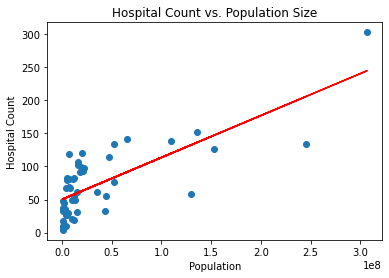

In [14]:
plt.title('Hospital Count vs. Population Size')
plt.xlabel('Population')
plt.ylabel('Hospital Count')
x = pop_hosp['Pop']
y = pop_hosp['Hospitals']
plt.plot(x, (np.polyfit(x,y,1))[0]*x + (np.polyfit(x,y,1))[1], color = 'red')
plt.scatter(x, y)
plt.show()

Based on the linear fit, it is easy to see that a larger population results in more hospitals. While this seems like an obvious statement, I had to start somewhere.

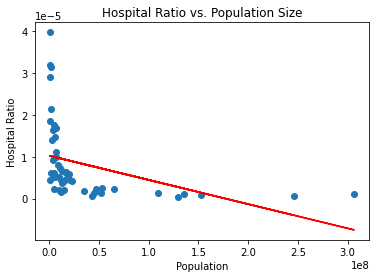

In [15]:
plt.title('Hospital Ratio vs. Population Size')
plt.xlabel('Population')
plt.ylabel('Hospital Ratio')
x = pop_hosp['Pop']
y = pop_hosp['Ratio']
plt.plot(x, (np.polyfit(x,y,1))[0]*x + (np.polyfit(x,y,1))[1], color = 'red')
plt.scatter(x, y)
plt.show()

Looking at the ratio of hospitals to population vs population however yield different results.  There looks to be a negative correlation to the number of hospitals per person as population increases. There are any number of reasons for this, but one explanation could be that States with larger populations, have more cities, and therefore since the concentration of population is greater, you get larger hospitals, but less.

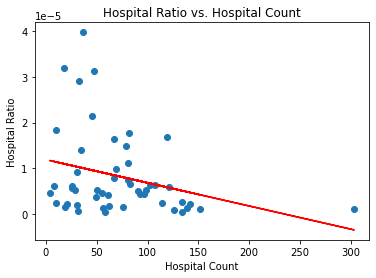

In [16]:
plt.title('Hospital Ratio vs. Hospital Count')
plt.xlabel('Hospital Count')
plt.ylabel('Hospital Ratio')
x = pop_hosp['Hospitals']
y = pop_hosp['Ratio']
plt.plot(x, (np.polyfit(x,y,1))[0]*x + (np.polyfit(x,y,1))[1], color = 'red')
plt.scatter(x, y)
plt.show()

So based on this graph I can see that as the number of hospitals increases, the amount of hospitals per person decreases. This is inline with what was boserved with the previous two graphs. A positive correlation between population size and hospital count, but a negative ratio between ratio and population would indicate that there would be negative correlation between ration and hopsital count. Nothing surprising here.

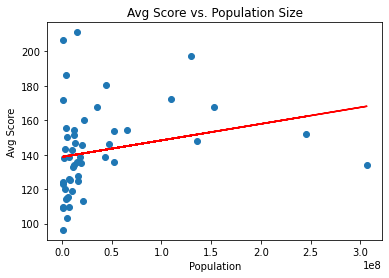

In [17]:
plt.title('Avg Score vs. Population Size')
plt.xlabel('Population')
plt.ylabel('Avg Score')
x = pop_hosp['Pop']
y = pop_hosp['Avg Score']
plt.plot(x, (np.polyfit(x,y,1))[0]*x + (np.polyfit(x,y,1))[1], color = 'red')
plt.scatter(x, y)
plt.show()

It does seem that the higher a population is, the longer it takes to wait in an emergancy room. That would start to make sense, considering there are also less hospitals to admit people, even if they are larger.

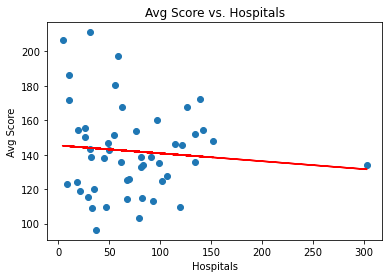

In [18]:
plt.title('Avg Score vs. Hospitals')
plt.xlabel('Hospitals')
plt.ylabel('Avg Score')
x = pop_hosp['Hospitals']
y = pop_hosp['Avg Score']
plt.plot(x, (np.polyfit(x,y,1))[0]*x + (np.polyfit(x,y,1))[1], color = 'red')
plt.scatter(x, y)
plt.show()

Here we can see that as the number of hospitals increases, the score tends to decrease. That would mean more hospitals is a good thing. More hospitals means more options and less waiting around to get admitted.

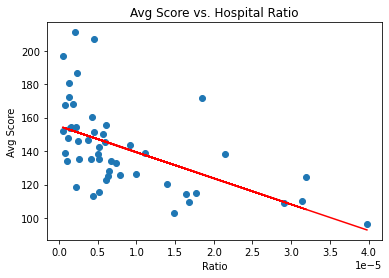

In [19]:
plt.title('Avg Score vs. Hospital Ratio')
plt.xlabel('Ratio')
plt.ylabel('Avg Score')
x = pop_hosp['Ratio']
y = pop_hosp['Avg Score']
plt.plot(x, (np.polyfit(x,y,1))[0]*x + (np.polyfit(x,y,1))[1], color = 'red')
plt.scatter(x, y)
plt.show()

This graph shows a stronger slope for the score vs ratio. Thism eans that a better hospital per person ratio results in shorter wait times. This again makes sense. If there are more options per person, then they can be moved through faster.

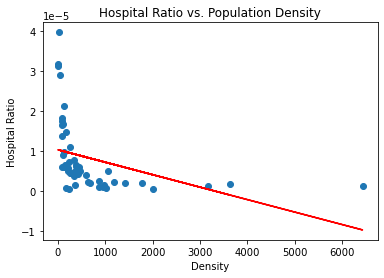

In [20]:
plt.title('Hospital Ratio vs. Population Density')
plt.xlabel('Density')
plt.ylabel('Hospital Ratio')
x = pop_hosp['Avg Density']
y = pop_hosp['Ratio']
plt.plot(x, (np.polyfit(x,y,1))[0]*x + (np.polyfit(x,y,1))[1], color = 'red')
plt.scatter(x, y)
plt.show()

This graph starts by showing that a high population density has a lower hospital ratio. That is not what you want. It seems that my earlier assumption about high density states, having larger  and fewer hospitals would be correct.

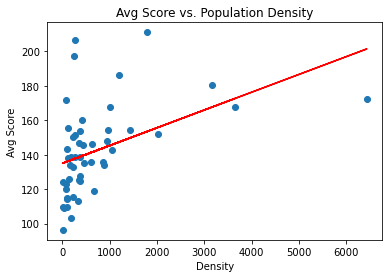

In [21]:
plt.title('Avg Score vs. Population Density')
plt.xlabel('Density')
plt.ylabel('Avg Score')
x = pop_hosp['Avg Density']
y = pop_hosp['Avg Score']
plt.plot(x, (np.polyfit(x,y,1))[0]*x + (np.polyfit(x,y,1))[1], color = 'red')
plt.scatter(x, y)
plt.show()

This graph also tells a good story about how a higher population dnesity tends to result in a higher average score. That definitely indicates that higher population density results in longer wait times.

## Conclusion:
Based on all of this we can safely say that a greater number of hospitals is more beneficial for people. This means that even smaller hospitals will help people. None of this accounts for severity, but if we assume an equal distribution of high to low severity, then lower severity patients would go to the smaller hospitals, freeing up the larger hospitals for the more serious conditions. So my recommendation would be that going to larger population densities and increasing the number of smaller hopsitals would help reduce wait times.